In [9]:
# File handling
import os
import pickle

# General functions
import numpy as np
import pandas as pd

# Sci-kit learn
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, PredefinedSplit
from sklearn.neural_network import MLPClassifier
import sklearn.pipeline
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import MinMaxScaler
# import sklearn.linear_model
# import sklearn.model_selection as skms
# import sklearn.feature_selection
# from sklearn.utils import shuffle
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Import our custom functions
from load_data import load_data 

Load training and validation data:

x data is an array of N*784 pixels (N = 2102 for tr, 600 for va)

y is a dataframe of index, class_name and class_id

In [10]:
x_tr, y_tr_df = load_data('x_train.csv', 'y_train.csv')
x_va, y_va_df = load_data('x_valid.csv', 'y_valid.csv')
x_te = load_data('x_test.csv', 'y_valid.csv')[0]


for label, arr in [('train', x_tr), ('valid', x_va)]:
    print("Contents of %s_x.csv: arr of shape %s" % (
        label, str(arr.shape)))

Contents of train_x.csv: arr of shape (2102, 784)
Contents of valid_x.csv: arr of shape (600, 784)


Plot a random image from the validation data for each category

# Model with Duplicate Data

In [11]:
#getting index for each class in training set:
top_int = y_tr_df.index[y_tr_df['class_name']=='top']    #index 1
trous_int = y_tr_df.index[y_tr_df['class_name']=='trouser']    #index 11
dress_int =(y_tr_df.index[y_tr_df['class_name']=='dress']).tolist()
pull_int =(y_tr_df.index[y_tr_df['class_name']=='pullover']).tolist()
sneaker_int =(y_tr_df.index[y_tr_df['class_name']=='sneaker']).tolist()
sandal_int =(y_tr_df.index[y_tr_df['class_name']=='sandal']).tolist()


#sneakers + sandals + tops + trous + dress + pullovers in new dataset.
train_x_2 = np.vstack((x_tr[sandal_int, :], x_tr[sneaker_int, :]))
tops800= np.tile(x_tr[top_int, :], (800, 1)) #make 800 copies of tops
train_x_2 = np.vstack((train_x_2, tops800)) # add 800 tops to sandals + sneakers
assert(train_x_2.shape == (2400, 784))  #checking dimensions

trous800 = np.tile(x_tr[trous_int, :], (800, 1))  #800 copies of trousers
train_x_2 = np.vstack((train_x_2, trous800)) # add 800 trousers
assert(train_x_2.shape == (3200, 784))  #checking dimensions

dress800 = np.tile(x_tr[dress_int, :], (2, 1))   #doubled dresses 400 to 800
assert(dress800.shape == (800, 784))
train_x_2 = np.vstack((train_x_2, dress800)) # add 800 dresses
assert(train_x_2.shape == (4000, 784))  #checking dimensions

pull800 = np.tile(x_tr[pull_int, :], (8, 1))
assert(pull800.shape == (800, 784))
train_x_2 = np.vstack((train_x_2, pull800)) # add 800 dresses
assert(train_x_2.shape == (4800, 784))

#making train_y_2
train_y_2 = np.tile(7, 800) 
train_y_2 = np.hstack((train_y_2, np.tile(5, 800)))
train_y_2 = np.hstack((train_y_2, np.tile(0, 800)))
train_y_2 = np.hstack((train_y_2, np.tile(1, 800)))
train_y_2 = np.hstack((train_y_2, np.tile(3, 800)))
train_y_2 = np.hstack((train_y_2, np.tile(2, 800)))

assert(train_y_2.shape == (4800, ))


In [12]:
# Combine training and validation datasets
x_dup_all = np.vstack((train_x_2, x_va))
y_dup_all = np.hstack((train_y_2, y_va_df['class_uid']))

print("Training X shape: %s\nValidation X shape: %s\nCombined X shape: %s\n" % (train_x_2.shape, x_va.shape, x_dup_all.shape))
print("Training Y shape: %s\nValidation Y shape: %s\nCombined Y shape: %s\n" % (train_y_2.shape, y_va_df['class_uid'].shape, y_dup_all.shape))

valid_dup_indicators = np.hstack([
    -1 * np.ones(train_y_2.shape[0]), #-1 = exclude this example in test split
    0 * np.ones(y_va_df.shape[0]), #0 = include in the first test split
    ])

# Define custom splitter to use only the validation dataset for hyperparameter selection
print("Splitter dimensions: %i" % (valid_dup_indicators.shape[0]))
my_dup_splitter = sklearn.model_selection.PredefinedSplit(valid_dup_indicators)

Training X shape: (4800, 784)
Validation X shape: (600, 784)
Combined X shape: (5400, 784)

Training Y shape: (4800,)
Validation Y shape: (600,)
Combined Y shape: (5400,)

Splitter dimensions: 5400


In [13]:
# # prng = np.random.RandomState(0)
# prng = np.random.RandomState()
# N = 3 # num examples of each class to show
# fig, axgrid = plt.subplots(N, 6, figsize=(6*3, N*2.5))

# for ll, label in enumerate(['dress', 'pullover', 'top', 'trouser', 'sandal', 'sneaker']):
#     match_df = y_dup_all == label
#     match_ids_N = prng.choice(match_df.index, size=N)        
#     for ii, row_id in enumerate(match_ids_N):
#         ax = axgrid[ii, ll]
#         x_SS = x_dup_all[row_id].reshape((28,28))
#         ax.imshow(x_SS, vmin=0, vmax=255, cmap='gray')
#         ax.set_xticks([]); ax.set_yticks([]);
#         if ii == 0:
#             ax.set_title(label, fontsize=16)
# plt.subplots_adjust(left=0.01, right=0.99, wspace=.2, hspace=.01)
# plt.tight_layout();
# plt.show();

# Data Exploration 1a

In [14]:
# tr_class_dist = y_dup_all['class_name'].value_counts()
# val_class_dist = y_va_df['class_name'].value_counts()

# print('Training class distribution:\n' + str(tr_class_dist))
# print('Validation class distribution:\n' + str(val_class_dist))


The training data is heavily skewed with data from sandals and trainers, with only one training image for 2 classes. A challenge will be gaining a balanced weighting for each of the classes such that the dominant classes aren't always favoured by the classifier.

# Model

Run search with predefined split s.t. validation set is used for hyperparameter selection

# Coarse Grid search as per Preetish

In [15]:
# Removed following parameters that don't apply to lbfgs:
# batch size only for non-lbfgs. 
# Learning Rate = const, adaptive, etc... ONLY for sgd
# learning_rate_init only used for sgd or adam
# early_stopping, n_iter_no_change and validation_fraction only for sgd/adam.

scaling = False
flag = 'run'
if scaling:
    filename = '1D_coarse_grid_search.sav'
else:
    filename = '1D_coarse_grid_searchNoScaling.sav'

if os.path.isfile("./" + filename) and flag != 'run':
    grid_1D_model = pickle.load(open(filename, 'rb'))
else:
    rand_param_dist = dict(hidden_layer_sizes=[(10,),(20,),(50,),(100,)], activation=('identity', 'relu'), max_iter = np.logspace(1,2.6,6,dtype=int), alpha = np.logspace(-5,3,9))

    grid_1D_model =   sklearn.pipeline.Pipeline([
        ('scaling', MinMaxScaler()),
        ('grid_search', GridSearchCV(MLPClassifier(solver='lbfgs', random_state=0), rand_param_dist, scoring='balanced_accuracy', error_score='raise', return_train_score=True, cv= my_dup_splitter, n_jobs = -1, refit= False))
    ])

    # Fit on x_all as the custom splitter will divide this into tr and val
    grid_1D_model.fit(x_dup_all, y_dup_all)
    pickle.dump(grid_1D_model, open(filename, 'wb'))

Extract best values from grid search to make best estimator

In [16]:
# When refit is true we can use the best_estimator_ method, but this doesn't work with refit=false - here we need to manually run a fit on our training set.
gridRes = grid_1D_model['grid_search'].cv_results_
bestIdx = grid_1D_model['grid_search'].best_index_ 

testScore = gridRes['mean_test_score']

# print(testScore)
# print(gridRes['params'][bestIdx])

bestAlpha = gridRes['params'][bestIdx]['alpha']
bestLayer = gridRes['params'][bestIdx]['hidden_layer_sizes']
bestActivation = gridRes['params'][bestIdx]['activation']
bestMaxIter = gridRes['params'][bestIdx]['max_iter']

print("Grid search results:\nBest index %i with Balanced Accuracy: %f\nAlpha: %f\nLayer: %s\nActivation: %s\nMax_iter: %i" % (bestIdx,testScore[bestIdx],bestAlpha,str(bestLayer),bestActivation,bestMaxIter))

Grid search results:
Best index 426 with Balanced Accuracy: 0.711667
Alpha: 1000.000000
Layer: (100,)
Activation: relu
Max_iter: 10


Recreate best model

In [17]:
# Model with params from best index
bestMLP1Dgrid =   sklearn.pipeline.Pipeline([
        ('scaling', MinMaxScaler()),
        ('MLP', MLPClassifier(solver='lbfgs', shuffle=True, random_state=0, activation=bestActivation, alpha=bestAlpha, hidden_layer_sizes=bestLayer, max_iter=bestMaxIter))])
bestMLP1Dgrid.fit(x_tr,y_tr_df["class_name"])

pred_tr = bestMLP1Dgrid.predict(x_tr)
pred_va = bestMLP1Dgrid.predict(x_va)
pred_te = bestMLP1Dgrid.predict(x_te)

tr_acc = balanced_accuracy_score(y_tr_df['class_name'], pred_tr)
va_acc = balanced_accuracy_score(y_va_df['class_name'], pred_va)
print("Training balanced accuracy: %f\nValidation balanced accuracy: %f" % (tr_acc, va_acc))


# # # Save output of prediction on test data to a file.
# np.savetxt('yhat_test.txt', pred_te, delimiter='\n', fmt='%s');

Training balanced accuracy: 0.415208
Validation balanced accuracy: 0.413333


c:\Users\avtar\micromamba\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Evaluate alpha - other values are from best estimator

In [18]:
scaling = False
flag = 'run'
if scaling:
    filename = '1D_alphaGrid_search.sav'
else:
    filename = '1D_alphaGrid_NoScaling.sav'

if os.path.isfile("./" + filename) and flag != 'run':
    grid_1D_model = pickle.load(open(filename, 'rb'))
else:
    ### Evaluate alpha!

    # Create a MLP classifier
    MLP1D_EvalHype =   MLPClassifier(solver='lbfgs', activation=bestActivation, hidden_layer_sizes=bestLayer, max_iter=bestMaxIter)
    # Hyperparameters distributions - regularization strength alpha

    alphaDist = np.logspace(-4,6,7)
    randStateDist = range(0,16,1)
    distEvalHype = dict(alpha = alphaDist, random_state=randStateDist) #[10**(-4), optParams['C'], 10**6])

    #Pipeline starts!
    evalHypeParamAlphaPipe = sklearn.pipeline.Pipeline([
            ('scaling', MinMaxScaler()),
        ('grid_search', GridSearchCV(MLP1D_EvalHype, distEvalHype, cv=my_dup_splitter, verbose=0, error_score='raise', scoring='balanced_accuracy', return_train_score=True, refit= False, n_jobs = 1))
    ])

    evalHypeParamAlphaPipe.fit(x_dup_all, y_dup_all)

    alphaRes = evalHypeParamAlphaPipe['grid_search'].cv_results_
    bestIdx2 = evalHypeParamAlphaPipe['grid_search'].best_index_ 

    testScore = alphaRes['mean_test_score']

    bestAlpha2 = alphaRes['params'][bestIdx2]['alpha']

    print("Grid search results:\nBest index %i with Balanced Accuracy: %f\nAlpha: %f\nLayer: %s\nActivation: %s\nMax_iter: %i" % (bestIdx2,testScore[bestIdx2],bestAlpha2,str(bestLayer),bestActivation,bestMaxIter))
    pickle.dump(evalHypeParamAlphaPipe, open(filename, 'wb'))

c:\Users\avtar\micromamba\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\avtar\micromamba\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\avtar\micromamba\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs faile

Grid search results:
Best index 68 with Balanced Accuracy: 0.621667
Alpha: 464.158883
Layer: (100,)
Activation: relu
Max_iter: 10


c:\Users\avtar\micromamba\envs\cs135_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Evaluate num units in layer - other values are from best estimator and previous alpha search

In [19]:
scaling = False
flag = 'run'
if scaling:
    filename = '1D_layerGrid_search.sav'
else:
    filename = '1D_layerGrid_NoScaling.sav'

if os.path.isfile("./" + filename) and flag != 'run':
    grid_1D_model = pickle.load(open(filename, 'rb'))
else:
    ### Evaluate Number of Units!

    # Create a MLP classifier
    MLP1D_EvalHype = MLPClassifier(solver='lbfgs', activation=bestActivation, alpha=bestAlpha2, max_iter=bestMaxIter)
    # Hyperparameters distributions - regularization strength alpha

    layerDist = [(1,),(6,),(8,),(10,),(12,),(15,),(20,),(24,),(30,),(40,),(50,),(75,),(100,)]

    randStateDist = range(0,16,1)
    distEvalHype = dict(hidden_layer_sizes = layerDist, random_state=randStateDist)

    #Pipeline starts!
    evalHypeParamLayerPipe =  sklearn.pipeline.Pipeline([
        ('scaling', MinMaxScaler()),
        ('grid_search', GridSearchCV(MLP1D_EvalHype, distEvalHype, cv=my_dup_splitter, verbose=0, error_score='raise', scoring='balanced_accuracy', return_train_score=True, refit= False, n_jobs = -1))
    ])

    evalHypeParamLayerPipe.fit(x_dup_all, y_dup_all)

    layerRes = evalHypeParamLayerPipe['grid_search'].cv_results_
    bestIdx3 = evalHypeParamLayerPipe['grid_search'].best_index_ 

    testScore = layerRes['mean_test_score']

    bestLayer3 = layerRes['params'][bestIdx3]['hidden_layer_sizes']

    print("Grid search results:\nBest index %i with Balanced Accuracy: %f\nAlpha: %f\nLayer: %s\nActivation: %s\nMax_iter: %i" % (bestIdx3,testScore[bestIdx3],bestAlpha2,str(bestLayer3),bestActivation,bestMaxIter))
    pickle.dump(evalHypeParamLayerPipe, open(filename, 'wb'))

Grid search results:
Best index 174 with Balanced Accuracy: 0.768333
Alpha: 464.158883
Layer: (50,)
Activation: relu
Max_iter: 10


Evaluate max iter - other values are from best estimator and previous alpha and layer search

In [21]:
scaling = False
flag = 'run'
if scaling:
    filename = '1D_layerGrid_search.sav'
else:
    filename = '1D_layerGrid_NoScaling.sav'

if os.path.isfile("./" + filename) and flag != 'run':
    grid_1D_model = pickle.load(open(filename, 'rb'))
else:
    ### Evaluate Max_iter (i.e. early stopping for lbfgs)!

    # Create a MLP classifier
    MLP1D_EvalHype = MLPClassifier(solver='lbfgs', activation=bestActivation, alpha=bestAlpha2, hidden_layer_sizes = bestLayer3)
    # Hyperparameters distributions - max iterations
    max_iterDist = np.logspace(1,2.6,15,dtype=int)

    randStateDist = range(0,16,1)
    distEvalHype = dict(max_iter = max_iterDist, random_state=randStateDist)

    #Pipeline starts!
    evalHypeParamIterPipe =  sklearn.pipeline.Pipeline([
        ('scaling', MinMaxScaler()),
        ('grid_search', GridSearchCV(MLP1D_EvalHype, distEvalHype, cv=my_dup_splitter, verbose=0, error_score='raise', scoring='balanced_accuracy', return_train_score=True, refit= False, n_jobs = -1))
    ])

    evalHypeParamIterPipe.fit(x_dup_all, y_dup_all)


    iterRes = evalHypeParamIterPipe['grid_search'].cv_results_
    bestIdx4 = evalHypeParamIterPipe['grid_search'].best_index_ 

    testScore = iterRes['mean_test_score']

    bestIter4 = iterRes['params'][bestIdx4]['max_iter']

    print("Grid search results:\nBest index %i with Balanced Accuracy: %f\nAlpha: %f\nLayer: %s\nActivation: %s\nMax_iter: %i" % (bestIdx4,testScore[bestIdx4],bestAlpha2,str(bestLayer3),bestActivation,bestIter4))
    pickle.dump(evalHypeParamIterPipe, open(filename, 'wb'))

Grid search results:
Best index 14 with Balanced Accuracy: 0.768333
Alpha: 464.158883
Layer: (50,)
Activation: relu
Max_iter: 10


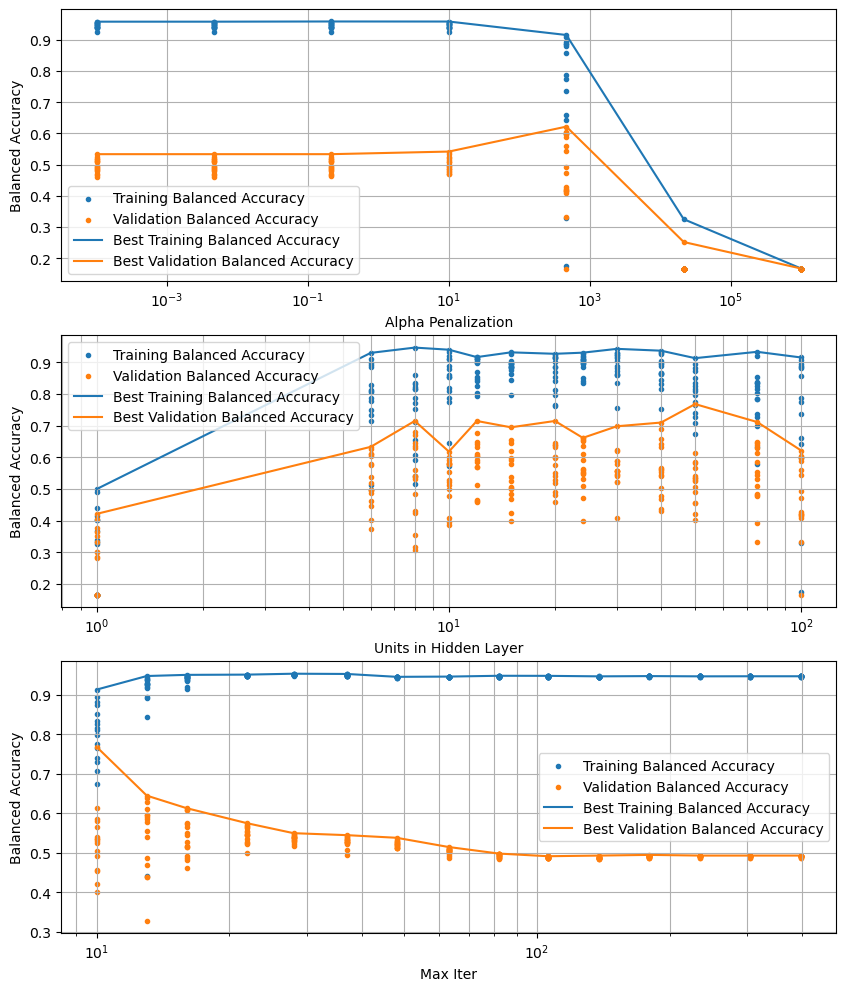

In [22]:
# Extract Alpha data for plotting
# alphaRes = evalHypeParamAlphaPipe['grid_search'].cv_results_
# reshape to rows of one alpha, with columns of different random seeds
alphaScoreTrainReshape = alphaRes['mean_train_score'].reshape((len(alphaDist),16))
alphaScoreValReshape = alphaRes['mean_test_score'].reshape((len(alphaDist),16))

# Select best runs for each alpha
alpha_Train = np.max(alphaScoreTrainReshape,axis=1)
alpha_Val = np.max(alphaScoreValReshape,axis=1)
# Make second alphaDist to be used for scatter plot (i.e. values repeated for each rand state)
alphaDistRep = alphaRes['param_alpha']

# Extract layer data for plotting
layerRes = evalHypeParamLayerPipe['grid_search'].cv_results_
# reshape to rows of one layer size, with columns of different random seeds
layerScoreTrainReshape = layerRes['mean_train_score'].reshape((len(layerDist),16))
layerScoreValReshape = layerRes['mean_test_score'].reshape((len(layerDist),16))

# Select best runs for each layer size
layer_Train = np.max(layerScoreTrainReshape,axis=1)
layer_Val = np.max(layerScoreValReshape,axis=1)
# Make second layerDist to be used for scatter plot (i.e. values repeated for each rand state)
layerDistUnpack = [e for e, in layerDist]
layerDistRep = np.repeat(layerDistUnpack,16)

# # Extract max_iter data for plotting
# IterRes = evalHypeParamAlphaPipe['grid_search'].cv_results_
# reshape to rows of one max_iter, with columns of different random seeds
iterScoreTrainReshape = iterRes['mean_train_score'].reshape((len(max_iterDist),16))
iterScoreValReshape = iterRes['mean_test_score'].reshape((len(max_iterDist),16))

# Select best runs for each iter
iter_Train = np.max(iterScoreTrainReshape,axis=1)
iter_Val = np.max(iterScoreValReshape,axis=1)
# Make second iterDist to be used for scatter plot (i.e. values repeated for each rand state)
iterDistRep = iterRes['param_max_iter']


# Plot accuracy vs alpha, layer and max_iter hyperparameters

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10,12))
ax1.scatter(alphaDistRep, alphaRes['mean_train_score'], label='Training Balanced Accuracy',marker='.')
ax1.scatter(alphaDistRep, alphaRes['mean_test_score'], label='Validation Balanced Accuracy',marker='.')
ax1.plot(alphaDist, alpha_Train, label='Best Training Balanced Accuracy')
ax1.plot(alphaDist, alpha_Val, label='Best Validation Balanced Accuracy')
ax1.legend()
ax1.set_xlabel('Alpha Penalization')
ax1.set_ylabel('Balanced Accuracy')
ax1.set_xscale('log')
ax1.grid(which='both')

ax2.scatter(layerDistRep, layerRes['mean_train_score'], label='Training Balanced Accuracy',marker='.')
ax2.scatter(layerDistRep, layerRes['mean_test_score'], label='Validation Balanced Accuracy',marker='.')
ax2.plot(layerDistUnpack, layer_Train, label='Best Training Balanced Accuracy')
ax2.plot(layerDistUnpack, layer_Val, label='Best Validation Balanced Accuracy')
ax2.legend()
ax2.set_xlabel('Units in Hidden Layer')
ax2.set_ylabel('Balanced Accuracy')
ax2.set_xscale('log')
ax2.grid(which='both')

ax3.scatter(iterDistRep, iterRes['mean_train_score'], label='Training Balanced Accuracy',marker='.')
ax3.scatter(iterDistRep, iterRes['mean_test_score'], label='Validation Balanced Accuracy',marker='.')
ax3.plot(max_iterDist, iter_Train, label='Best Training Balanced Accuracy')
ax3.plot(max_iterDist, iter_Val, label='Best Validation Balanced Accuracy')
ax3.legend()
ax3.set_xlabel('Max Iter')
ax3.set_ylabel('Balanced Accuracy')
ax3.set_xscale('log')
ax3.grid(which='both')


In [24]:
sklearn.metrics.ConfusionMatrixDisplay.from_estimator(evalHypeParamIterPipe['class_uid'], x_va, y_va_df['class_uid'])

#id_label = dict(labels = {'dress', 'pullover', 'top', 'trouser', 'sandal', 'sneaker'}, class_id = {3, 2, 0, 1, 5, 7})

KeyError: 'class_uid'